In [1]:
%matplotlib inline

import os
import time
import math
import glob
import shutil
import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt
import h5py

from pathlib import Path
from torch.utils.data import Dataset, DataLoader, sampler
from PIL import Image

import torch
from torch.nn import functional as F
from torch.autograd import Variable

##############################
from models import tiramisu
from datasets import datasets
from utils import manager as mgr
from utils import metrics
from utils import losses
from utils import log
from utils import img_utils
##############################

nr_classes = 4
nr_channels = 7
exp_name = 'fcdensenet_df_012_001'
DEVICE = "cuda:0"
WEIGHTS_PATH = 'weights/'+exp_name+'/'

# set device
#device = torch.device(DEVICE if torch.cuda.is_available() else "cpu")
device = "cuda:0"
#device = "cpu"
print(device)

batch_size = 8
split={'train':0.01, 'val':0.01, 'test':0.1}
num_workers=4
pin_memory=True

LR = 0.006
LR_DECAY = 0.995
DECAY_EVERY_N_EPOCHS = 1
N_EPOCHS = 1

cuda:0


In [2]:
## Initialise logging
logging = log.Log(exp_name)

## Create the dataset
#path_dataset = "/home/philipp/Data/dataset_256_df_0.h5"
path_dataset = "/media/philipp/DATA/dataset/dataset_256_df_0.h5"
dataset = datasets.ForestDataset(path_dataset)

# shuffle and split
train_sampler, val_sampler, test_sampler = dataset.get_sampler(split=split, shuffle_dataset=True, random_seed=399)

# dataloader
train_dl = torch.utils.data.DataLoader(dataset, batch_size=batch_size, \
                                sampler=train_sampler, num_workers=4, pin_memory=True)
val_dl = torch.utils.data.DataLoader(dataset, batch_size=batch_size, \
                                sampler=val_sampler, num_workers=4, pin_memory=True)
test_dl = torch.utils.data.DataLoader(dataset, batch_size=batch_size, \
                                sampler=test_sampler, num_workers=4, pin_memory=True)
print(len(dataset))
print(len(train_sampler.indices))
print(len(val_sampler.indices))
print(len(test_sampler.indices))

39280
392
392
3928


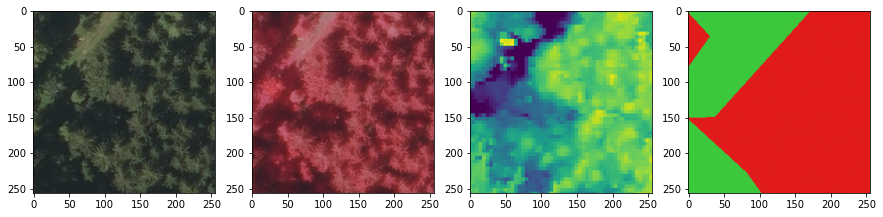

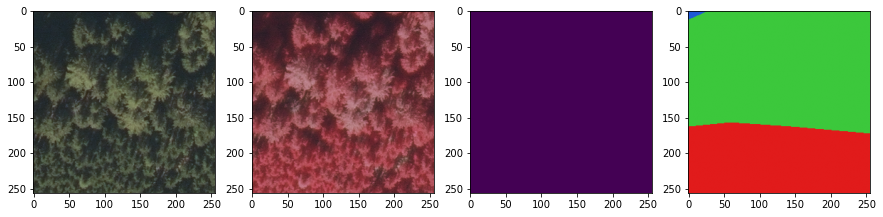

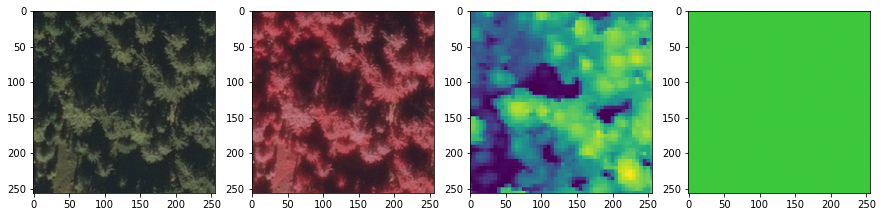

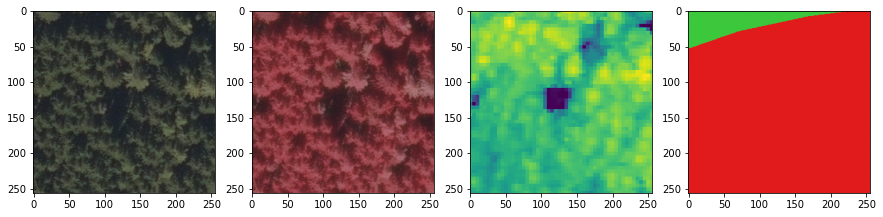

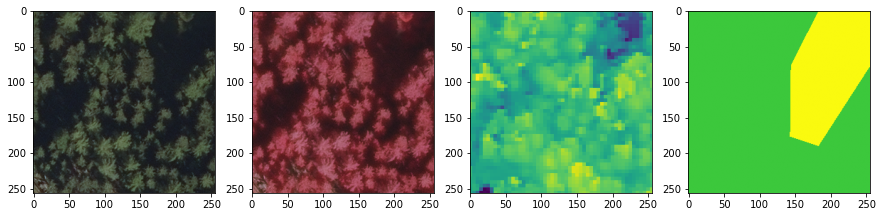

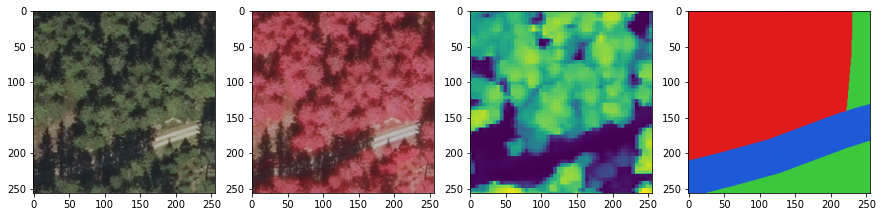

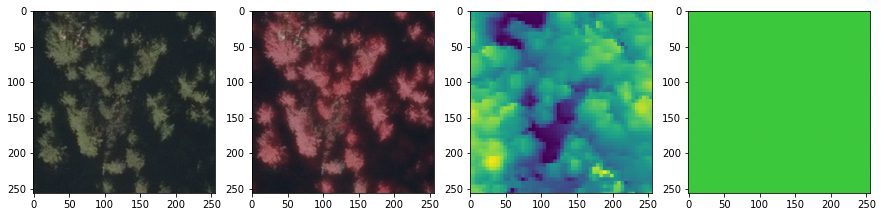

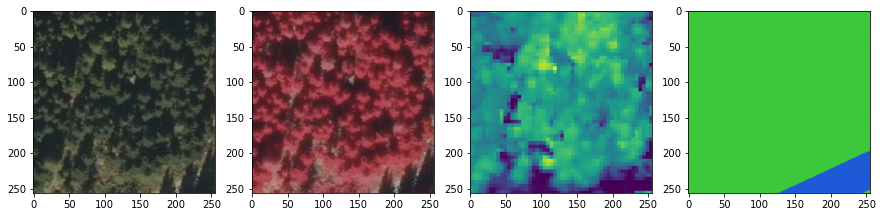

In [3]:
# show examples
img_utils.view_sample(train_dl, 10)

In [4]:
#############
#   train
#############
def train(model, trn_loader, optimizer, criterion, epoch):
    
    model.train()
    step = 0
    metric = {'loss': 0.0, \
              'acc_all':0.0, \
              'acc_mean':0.0, \
              'jacc':0.0, \
              'dice':0.0}

    for idx, data in enumerate(trn_loader):
        x = Variable(data[0].to(device))
        y = Variable(data[1].to(device))
        step += 1
        
        # forward pass
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        
        # backward pass
        loss.backward()
        # update weights
        optimizer.step()

        # calculate predictions
        pred = mgr.get_predictions(output)
        
        # calculate metrics for the batch
        overall_acc, avg_per_class_acc, avg_jacc, avg_dice = metrics.eval_metrics(y, pred, num_classes=nr_classes, device=device)
        # update running metrics
        for i, m in zip(metric, [loss, overall_acc, avg_per_class_acc, avg_jacc, avg_dice]):
            metric[i] += m*trn_loader.batch_size
        
        # print metrics to console
        if step % 100 == 0:
            print('Step: {}  Loss: {:.4f}  Acc all: {:.4f}  Acc mean: {:.4f}  IoU: {:.4f}  Dice: {:.4f}'\
                  .format(step, loss, overall_acc, avg_per_class_acc, avg_jacc, avg_dice))
    
    # calculate metrics for the epoch      
    for i in metric:
        metric[i] /= len(train_sampler.indices)
                    
    return metric

#############
#   test
#############
def test(model, test_loader, criterion, epoch=1):
    
    model.eval()
    step = 0
    metric = {'loss': 0.0, \
              'acc_all':0.0, \
              'acc_mean':0.0, \
              'jacc':0.0, \
              'dice':0.0}
    
    for data, target in test_loader:
        x = Variable(data.to(device))
        y = Variable(target.to(device))
        step += 1
        
        # forward pass
        with torch.no_grad():
            output = model(x)
            loss = criterion(output, y)
            #test_loss += criterion(output, y).data.item()
            
        # calculate predictions    
        pred = mgr.get_predictions(output)
        
        # calculate metrics for the batch
        overall_acc, avg_per_class_acc, avg_jacc, avg_dice = metrics.eval_metrics(y, pred, num_classes=nr_classes, device=device)
        # update running metrics
        for i, m in zip(metric, [loss, overall_acc, avg_per_class_acc, avg_jacc, avg_dice]):
            metric[i] += m*test_loader.batch_size
            
        # print metrics to console
        if step % 100 == 0:
            print('Step: {}  Loss: {:.4f}  Acc all: {:.4f}  Acc mean: {:.4f}  IoU: {:.4f}  Dice: {:.4f}'\
                  .format(step, loss, overall_acc, avg_per_class_acc, avg_jacc, avg_dice))
        
    # calculate metrics for the epoch      
    for i in metric:
        metric[i] /= len(val_sampler.indices)
                    
    return metric

In [6]:
# define model
model = tiramisu.FCDenseNet67(in_channels=nr_channels, n_classes=nr_classes)

try:
    mgr.load_weights(model, WEIGHTS_PATH+'weights-19-0.217-0.821.pth')
    #load_weights(model, WEIGHTS_PATH+'latest_5d.pt')
    print("weights loaded")
except:
    model.apply(mgr.weights_init)
    print("no weights found")
    
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = losses.Dice_Loss()

loading weights 'weights/fcdensenet_df_012_001/weights-19-0.217-0.821.pth'
no weights found


/home/philipp/Code/python/edin_deep_learing_fcdensenet/utils/manager.py:56: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(m.weight)


In [8]:
logging.start_log(LR, N_EPOCHS)
logging.start_csv()

for epoch in range(1, N_EPOCHS+1):
    since = time.time()
    
    print('-' * 10)
    print('Epoch {}/{}'.format(epoch, N_EPOCHS))
    print('-' * 10)

    ### Train ###
    metric = train(model, train_dl, optimizer, criterion, epoch)
    # print metrics to console
    print('Epoch {}/{}'.format(epoch, N_EPOCHS))
    print('-' * 10)
    print('Train Loss: {:.4f}  Acc all: {:.4f}  Acc mean: {:.4f}  IoU: {:.4f}  Dice: {:.4f}'\
          .format(metric['loss'], metric['acc_all'], metric['acc_mean'], metric['jacc'], metric['dice']))
    print('-' * 10)
    time_elapsed = time.time() - since  
    print('Train Time {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    logging.add_log(epoch, metric, time_elapsed // 60, 'train')
    logging.add_csv(epoch, metric, time_elapsed // 60, 'train')
    
    ### Test ###
    metric = test(model, val_dl, criterion, epoch) 
    print('-' * 10)
    print('Val Loss: {:.4f}  Acc all: {:.4f}  Acc mean: {:.4f}  IoU: {:.4f}  Dice: {:.4f}'\
          .format(metric['loss'], metric['acc_all'], metric['acc_mean'], metric['jacc'], metric['dice']))
    print('-' * 10)
    time_elapsed = time.time() - since  
    print('Total Time {:.0f}m {:.0f}s\n'.format(time_elapsed // 60, time_elapsed % 60))
    logging.add_log(epoch, metric, time_elapsed // 60, 'val')
    logging.add_csv(epoch, metric, time_elapsed // 60, 'val')
    
    ### Checkpoint ###    
    mgr.save_weights(model, epoch, metric['loss'], metric['acc_all'])

    ### Adjust Lr ###
    mgr.adjust_learning_rate(LR, LR_DECAY, optimizer, epoch, DECAY_EVERY_N_EPOCHS)

----------
Epoch 1/1
----------
Epoch 1/1
----------
Train Loss: 0.3550  Acc all: 0.7864  Acc mean: 0.6806  IoU: 0.5719  Dice: 0.6655
----------
Train Time 0m 12s
----------
Val Loss: 0.3333  Acc all: 0.7676  Acc mean: 0.6962  IoU: 0.5872  Dice: 0.6871
----------
Total Time 0m 16s



In [ ]:
# TO DO
# plot traing loss
#plt.figure(figsize=(10,8))
#plt.plot(train_loss, label='Train loss')
#plt.plot(valid_loss, label='Valid loss')
#plt.legend()

In [18]:
# predict

In [7]:
test(model, test_dl, criterion, epoch=1)

Step: 100  Loss: 0.2733  Acc all: 0.7923  Acc mean: 0.7141  IoU: 0.5910  Dice: 0.7267
Step: 200  Loss: 0.2335  Acc all: 0.7904  Acc mean: 0.7166  IoU: 0.6344  Dice: 0.7665


{'loss': tensor(2.5018, device='cuda:0'),
 'acc_all': tensor(8.0571),
 'acc_mean': tensor(7.3164),
 'jacc': tensor(6.3365),
 'dice': tensor(7.5391)}

In [18]:
loader = val_dl

# get data
inputs, targets = next(iter(loader))
data = Variable(inputs.to(device))
label = Variable(targets.to(device))

# get predictions
with torch.no_grad():
    output = model(data)
pred = mgr.get_predictions(output)

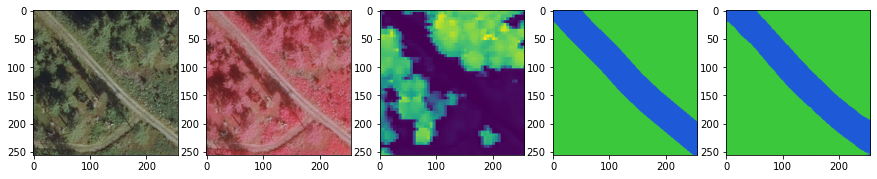

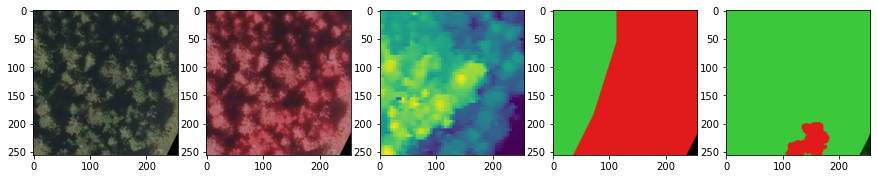

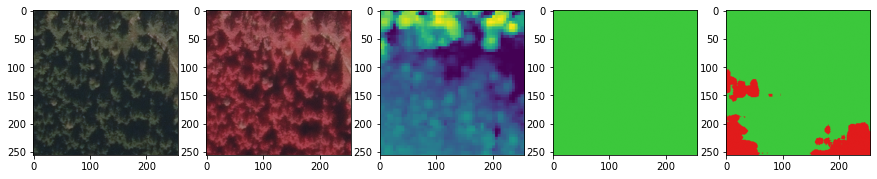

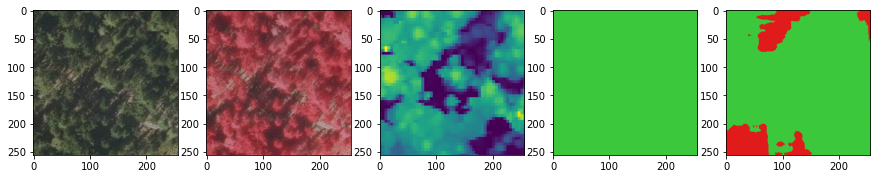

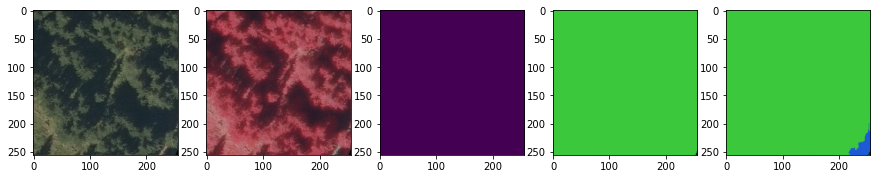

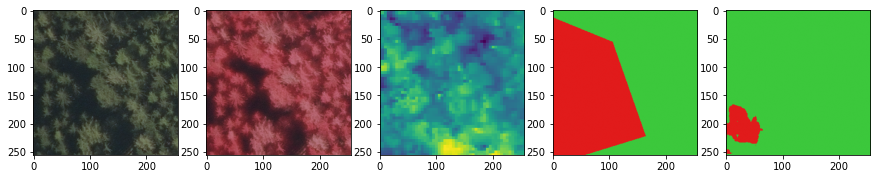

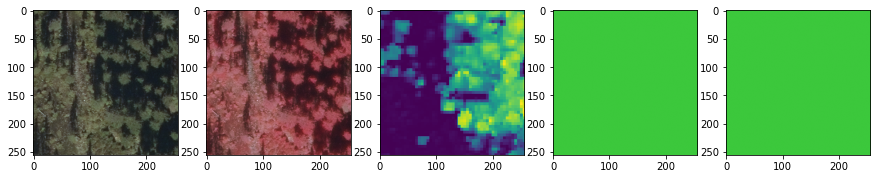

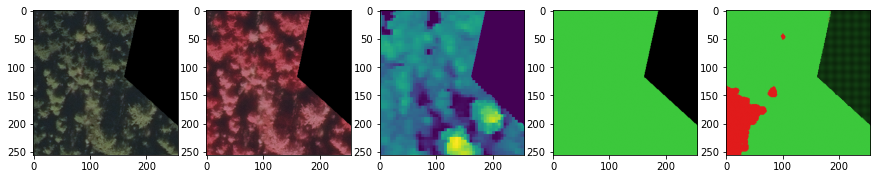

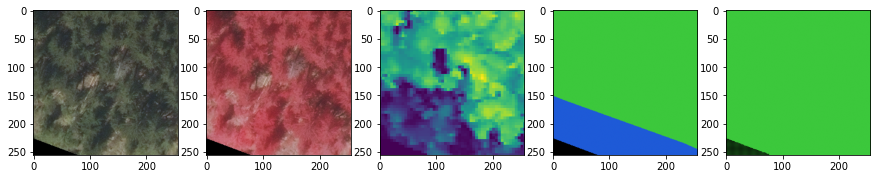

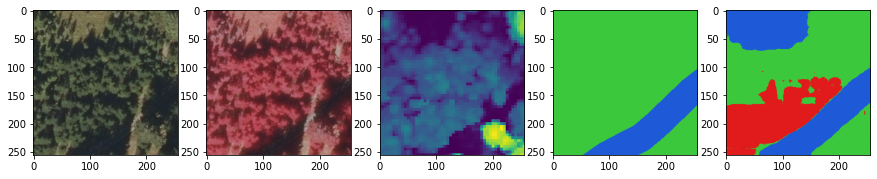

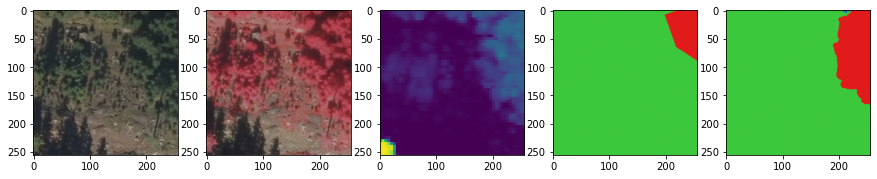

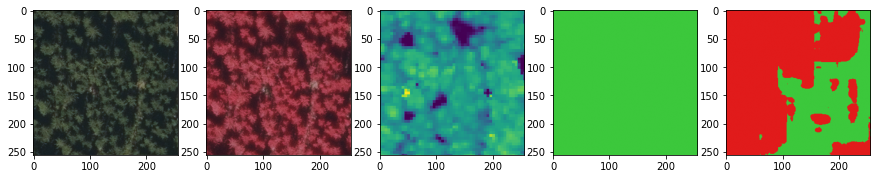

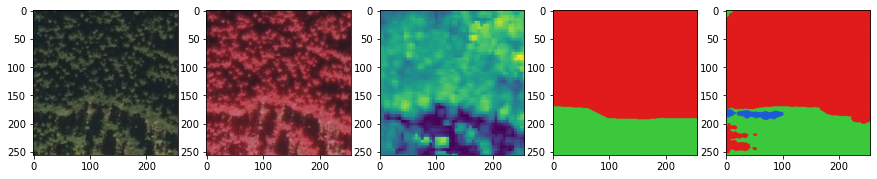

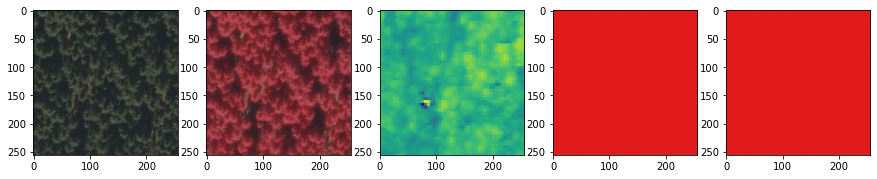

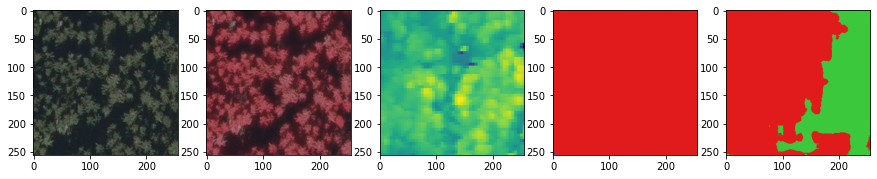

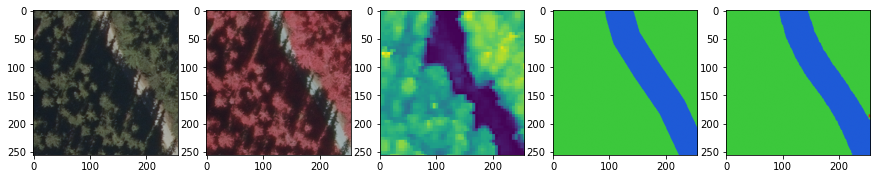

In [20]:
mgr.view_sample_predictions(model, loader=test_dl, n=16, device=device)

In [ ]:
# confusion matrix

In [69]:
torch.flatten(targets)

tensor([4, 4, 4,  ..., 2, 2, 2])

In [71]:
stacked = torch.stack((torch.flatten(targets), \
                       torch.flatten(pred)), dim=1)

In [72]:
stacked.shape

torch.Size([1048576, 2])

In [73]:
cmt = torch.zeros(5,5, dtype=torch.int64)

In [76]:
for p in stacked:
    tl, pl = p.tolist()
    cmt[tl, pl] = cmt[tl, pl] + 1

In [77]:
cmt

tensor([[ 18975,      0,      0,     18,      0],
        [     2,   7526,     93,  43528,      0],
        [     0,  33689,  60925,  57858,      0],
        [     0,  33366,  31799, 585020,   4011],
        [     0,     75,    134,  44075, 127482]])